In [1]:
import numpy as np
import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


/root/miniconda3/envs/envPytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('listing_filtered.csv')
y = 'number_of_reviews_l30d'

y_df = df[y]
x_df = df.drop(y, axis=1)
# x_df = x_df.drop('number_of_reviews_l30d',axis=1)
# x_df = x_df.drop('reviews_per_month',axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=42)
X_train.shape

(7179, 71)

In [3]:
x_df.shape

(10256, 71)

In [3]:

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# XGBoost

In [4]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    scores = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    return scores

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 最佳参数
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-05-30 00:48:22,280] A new study created in memory with name: no-name-aa52741a-685c-42fc-a8ce-45960eae920f
[I 2024-05-30 00:48:34,518] Trial 1 finished with value: 1.80865281573085 and parameters: {'n_estimators': 460, 'max_depth': 7, 'learning_rate': 0.24043972911044556, 'subsample': 0.5530034941132386, 'colsample_bytree': 0.7127083682482334, 'min_child_weight': 3, 'reg_alpha': 0.731770550584987, 'reg_lambda': 0.12001760170982012}. Best is trial 1 with value: 1.80865281573085.
[I 2024-05-30 00:48:38,399] Trial 5 finished with value: 1.7877899519689382 and parameters: {'n_estimators': 507, 'max_depth': 12, 'learning_rate': 0.2664997555743242, 'subsample': 0.7856798271458858, 'colsample_bytree': 0.6273673551957586, 'min_child_weight': 5, 'reg_alpha': 0.7121455817996247, 'reg_lambda': 0.8944219209413665}. Best is trial 5 with value: 1.7877899519689382.
[I 2024-05-30 00:48:41,631] Trial 20 finished with value: 1.7787169985690319 and parameters: {'n_estimators': 545, 'max_depth': 7,

Best parameters: {'n_estimators': 467, 'max_depth': 8, 'learning_rate': 0.013181978163537897, 'subsample': 0.5753224433468581, 'colsample_bytree': 0.6494862323697523, 'min_child_weight': 9, 'reg_alpha': 0.4105680677254606, 'reg_lambda': 0.06659113086416668}


In [5]:
import xgboost as xgb
# 给定的最佳参数
# params = {
#     'n_estimators': 520,
#     'max_depth': 7,
#     'learning_rate': 0.011687164270090028,
#     'subsample': 0.8199010735395122,
#     'colsample_bytree': 0.5464459364379836,
#     'min_child_weight': 9,
#     'reg_alpha': 0.44121292274725327,
#     'reg_lambda': 0.16276683410434623,
#     'random_state': 42,  # 确保可重复性
#     'objective': 'reg:squarederror'  # 明确指定回归任务
# }
# price
params = {
    'n_estimators': 941,
    'max_depth': 5,
    'learning_rate': 0.0397420863228438,
    'subsample': 0.6412996374546707,
    'colsample_bytree': 0.9194993776983482,
    'min_child_weight': 2,
    'reg_alpha': 0.23769141522549753,
    'reg_lambda': 0.5293795123054414,
    'random_state': 42,  # 确保可重复性
    'objective': 'reg:squarederror'  # 明确指定回归任务
}
# 创建XGBRegressor模型实例
model = xgb.XGBRegressor(**best_params)
# 在训练集上训练模型
model.fit(X_train, y_train)

# 使用测试数据进行预测
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

evaluate(y_test,test_pred)

Test set evaluation:
_____________________________________
MAE: 0.8363406189574453
MSE: 1.4515911591919008
RMSE: 1.2048199696186568
R2 Square 0.6070073297225328
Train set evaluation:
_____________________________________
MAE: 0.537685291362469
MSE: 0.5785828325634018
RMSE: 0.7606463255438771
R2 Square 0.8462210711134401


(0.8363406189574453,
 1.4515911591919008,
 1.2048199696186568,
 0.6070073297225328)

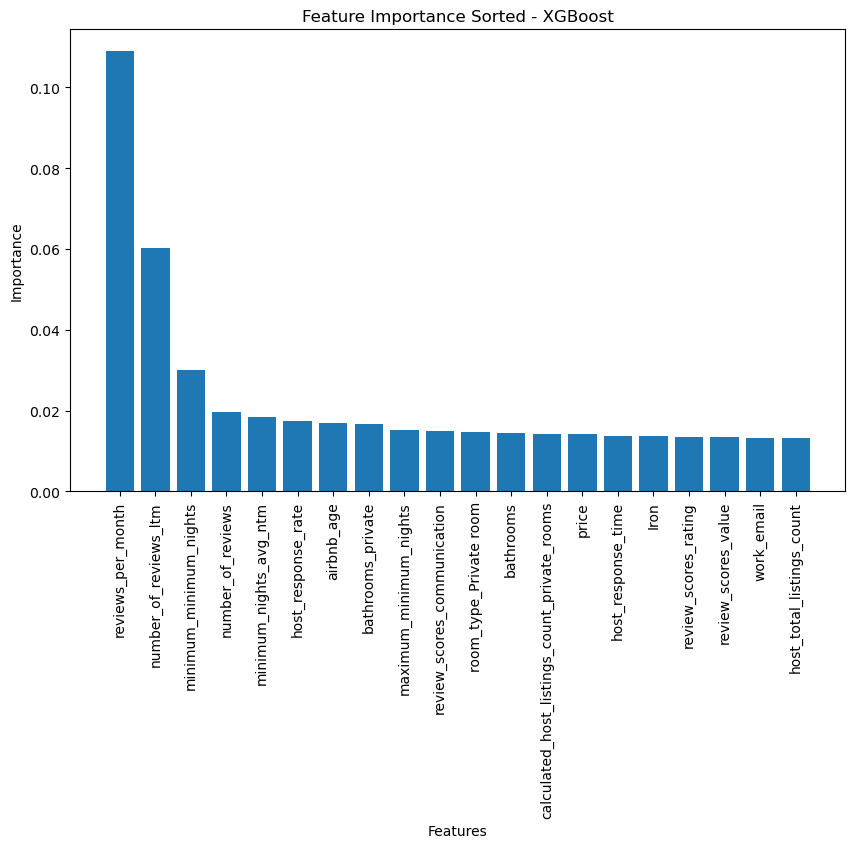

In [6]:
importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# 按照重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False).iloc[:20,:]
# 获取特征名（假设X_train是一个DataFrame）


plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Sorted - XGBoost')
plt.xticks(rotation='vertical')
plt.show()

# LinearRegression


In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# 使用测试数据进行预测
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred) 
evaluate(y_test,test_pred)

Test set evaluation:
_____________________________________
MAE: 0.9346619620186094
MSE: 1.740402631225712
RMSE: 1.319243203971774
R2 Square 0.5288167242737375
Train set evaluation:
_____________________________________
MAE: 0.9253730556412889
MSE: 1.6742658867670286
RMSE: 1.2939342667875477
R2 Square 0.5550043999791052


(0.9346619620186094, 1.740402631225712, 1.319243203971774, 0.5288167242737375)

# Lasso

In [21]:
X_train = pd.read_csv('X_train_boxcox_vif_filter.csv')
X_test = pd.read_csv('X_test_boxcox_vif_filter.csv')
y_train = pd.read_csv('y_train_boxcox_vif_filter.csv')
y_test = pd.read_csv('y_test_boxcox_vif_filter.csv')

In [22]:
from sklearn.linear_model import Lasso

def objective_lasso(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    model = Lasso(alpha=alpha, random_state=0)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(score)

    return -mean_score

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=20)

print("Best parameters for Lasso:", study_lasso.best_params)
print("Best cross-validation MSE for Lasso:", study_lasso.best_value)

[I 2024-05-30 01:03:17,044] A new study created in memory with name: no-name-722aef24-43d8-446d-8682-5dda72d44702
/tmp/ipykernel_3229949/89102485.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
[I 2024-05-30 01:03:17,134] Trial 0 finished with value: 0.1332508119195437 and parameters: {'alpha': 0.007044165240520931}. Best is trial 0 with value: 0.1332508119195437.
/tmp/ipykernel_3229949/89102485.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
[I 2024-05-30 01:03:17,197] Trial 1 finished with value: 0.14494079409983468 and parameters: {'alpha': 0.0939605428

Best parameters for Lasso: {'alpha': 0.00010550104742103153}
Best cross-validation MSE for Lasso: 0.1316459975491755


In [30]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0001)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred) 
evaluate(y_test,test_pred)

Test set evaluation:
_____________________________________
MAE: 0.3256863405414966
MSE: 0.15940145519046026
RMSE: 0.3992511179576837
R2 Square 0.45745636712357973
Train set evaluation:
_____________________________________
MAE: 0.3044932635409651
MSE: 0.13099345157710165
RMSE: 0.36193017500217034
R2 Square 0.5536394185226616


(0.3256863405414966,
 0.15940145519046026,
 0.3992511179576837,
 0.45745636712357973)

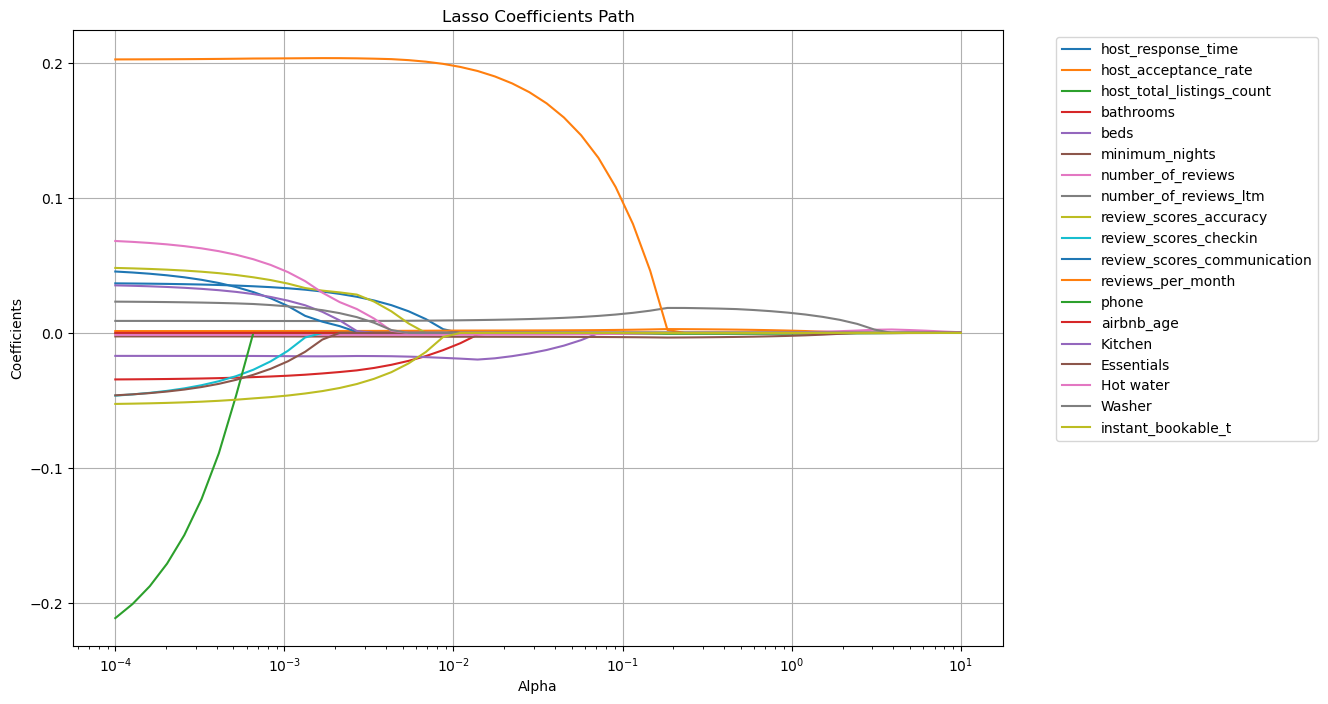

In [24]:
alphas = np.logspace(-4, 1, 50)
coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    coefficients.append(lasso.coef_)
coefficients = np.array(coefficients)

feature_names = X_train.columns

plt.figure(figsize=(12, 8))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=feature_names[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients Path')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


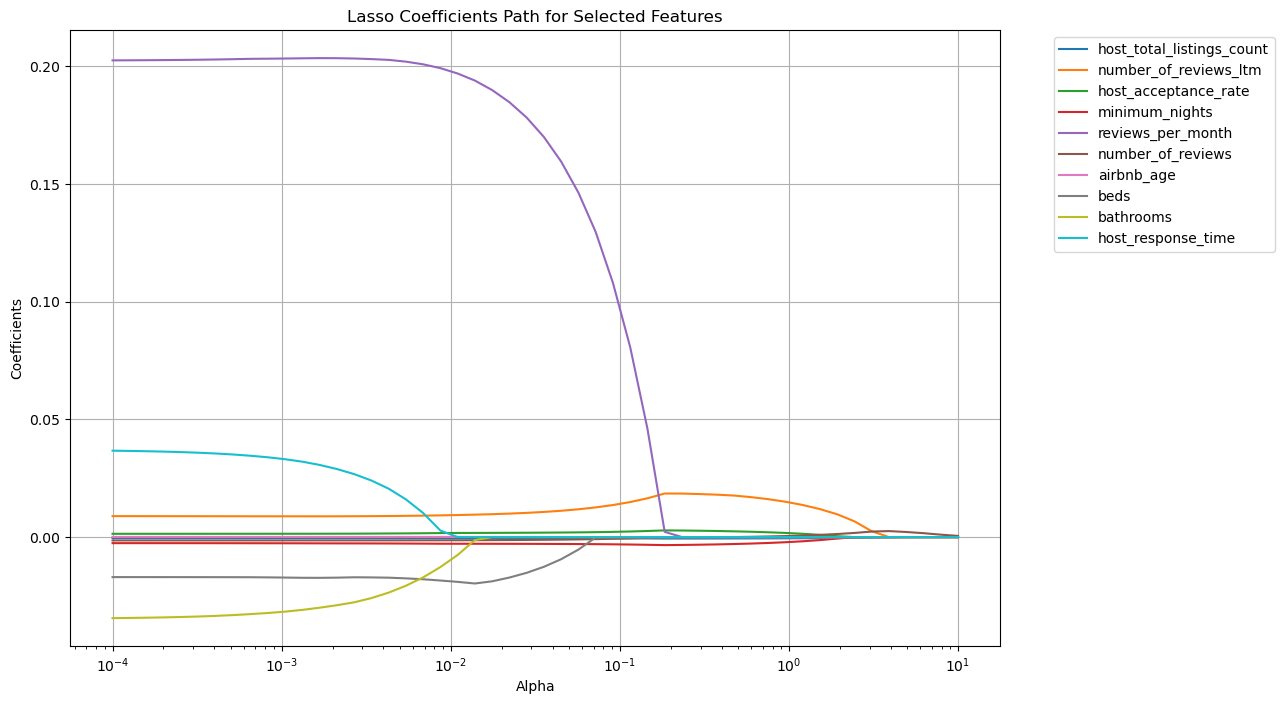

In [28]:
import matplotlib.pyplot as plt

selected_features =['host_total_listings_count',
 'number_of_reviews_ltm',
 'host_acceptance_rate',
 'minimum_nights',
 'reviews_per_month',
 'number_of_reviews',
 'airbnb_age',
 'beds',
 'bathrooms',
 'host_response_time']
feature_names = X_train.columns.tolist()
# 假设 feature_names 与 X_train 的列名对应且 coefficients 已经计算完毕
coefficients = np.array(coefficients)

# 绘制图形
plt.figure(figsize=(12, 8))
for feature_name in selected_features:
    index = feature_names.index(feature_name)  # 获取特征在 feature_names 中的索引
    plt.plot(alphas, coefficients[:, index], label=feature_name)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients Path for Selected Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [25]:
coefficients = np.array(coefficients)
zero_threshold = 1e-5  # 设置一个阈值，考虑到数值计算的精度问题
alpha_zero = []

for idx in range(coefficients.shape[1]):
    # 找到系数首次为零的索引
    found = np.where(np.abs(coefficients[:, idx]) < zero_threshold)[0]
    alpha_when_zero = alphas[found[0]] if found.size > 0 else np.nan  # 如果没有变为零，赋值为NaN
    alpha_zero.append((feature_names[idx], alpha_when_zero))

# 按alpha值排序，NaN将被排序到最后
alpha_zero_sorted = sorted(alpha_zero, key=lambda x: (x[1] is np.nan, -x[1]))
for feature, alpha in alpha_zero_sorted:
    if np.isnan(alpha):
        print(f"{feature} never went to zero")
    else:
        print(f"{feature} went to zero at alpha = {alpha:.6f}")

host_total_listings_count went to zero at alpha = 4.941713
number_of_reviews_ltm went to zero at alpha = 3.906940
host_acceptance_rate went to zero at alpha = 2.442053
minimum_nights went to zero at alpha = 2.442053
reviews_per_month went to zero at alpha = 0.232995
number_of_reviews went to zero at alpha = 0.184207
airbnb_age went to zero at alpha = 0.115140
beds went to zero at alpha = 0.091030
bathrooms went to zero at alpha = 0.017575
host_response_time went to zero at alpha = 0.010985
instant_bookable_t went to zero at alpha = 0.010985
review_scores_accuracy went to zero at alpha = 0.006866
Hot water went to zero at alpha = 0.005429
Washer went to zero at alpha = 0.005429
review_scores_communication went to zero at alpha = 0.003393
Kitchen went to zero at alpha = 0.003393
Essentials went to zero at alpha = 0.002121
review_scores_checkin went to zero at alpha = 0.001677
phone went to zero at alpha = 0.000655


In [26]:
df = pd.DataFrame(alpha_zero_sorted, columns=['Feature', 'Alpha_when_zero'])
df.to_csv('Lasso_features_by_alpha_zero.csv', index=False)

In [27]:
df.iloc[:10,:1]['Feature'].tolist()

['host_total_listings_count',
 'number_of_reviews_ltm',
 'host_acceptance_rate',
 'minimum_nights',
 'reviews_per_month',
 'number_of_reviews',
 'airbnb_age',
 'beds',
 'bathrooms',
 'host_response_time']

# Ridge

In [29]:
from sklearn.linear_model import Ridge
def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    model = Ridge(alpha=alpha, random_state=0)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(score)
    return -mean_score

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=50,n_jobs=-1)

print("Best parameters for Ridge:", study_ridge.best_params)
print("Best cross-validation MSE for Ridge:", study_ridge.best_value)


[I 2024-05-30 01:05:27,374] A new study created in memory with name: no-name-035731cc-3072-4d5c-94c6-6c224f7d4ffd
/tmp/ipykernel_3229949/3701458442.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
/tmp/ipykernel_3229949/3701458442.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
/tmp/ipykernel_3229949/3701458442.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alp

Best parameters for Ridge: {'alpha': 1.1910022771247797}
Best cross-validation MSE for Ridge: 0.13164095156665753


In [31]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.19)  # alpha是正则化强度
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred) 
evaluate(y_test,test_pred)

Test set evaluation:
_____________________________________
MAE: 0.32566995204136345
MSE: 0.15940134402946124
RMSE: 0.3992509787457775
R2 Square 0.4574567454745313
Train set evaluation:
_____________________________________
MAE: 0.3044370958400611
MSE: 0.13098861363831732
RMSE: 0.3619234914154058
R2 Square 0.5536559038136661


(0.32566995204136345,
 0.15940134402946124,
 0.3992509787457775,
 0.4574567454745313)